#### Summary:
This is based on my second version model interpretation notebook, modified from one Zeyang shared. It reads in the positive peak sequences (based on methods from the previous notebook) and then uses DeepLift to calculate nt importance scores for all of them. Then it has some preliminary visualization techniques. Here we are using it to repeat previous interpretation methods on my new set of models.

#### Changes from the original version:
- Combining peaks from control and AMLN sets into one peak set... use mergePeaks and then take the union; if they overlap, take the 300bp center
- Remove peaks not predicted to be positive (based on model.predict and a 0.05 threshold) --> consider if we want to standardize these by the 2 model's predictions???
- Going to considering predictions from Zeyang's IL4 model so generating importance scores from this (BUT NOT cutting down peaks based on them)

#### New Considerations - CHANGES FROM PREV V3 NOTEBOOK:
- Which peaks sets to generate importance scores from??? --> start with the same one as used previously in v2(all peaks found in BOTH datasets, then narrow down based on if the models predict them + or not)

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from itertools import compress

# Read in the combined peak file

In [4]:
#reading in the mergePeaks file (should be the union!)
cur_dir = "/home/hmummey/data/ATAC/combined_peaks/"
file_name = "mergePeaks_C57_control_C57_AMLNDiet_given.txt"
merged_peaks = pd.read_table(cur_dir+file_name)
print(len(merged_peaks))
merged_peaks.head()

23391


,#name (cmd = mergePeaks -d given ./C57_control_filt_annot_cut.bed ./C57_AMLNDiet_filt_annot_cut.bed),chr,start,end,strand,Stat,Parent files,Total subpeaks,./C57_control_filt_annot_cut.bed,./C57_AMLNDiet_filt_annot_cut.bed
0,Merged-chr8-40595479-1,chr8,40594980,40595979,+,0.0,./C57_AMLNDiet_filt_annot_cut.bed,1,NaN,default-4066
1,Merged-chr17-47395761-1,chr17,47395262,47396261,+,0.0,./C57_AMLNDiet_filt_annot_cut.bed,1,NaN,default-4069
2,Merged-chr6-127351804-1,chr6,127351305,127352304,+,0.0,./C57_AMLNDiet_filt_annot_cut.bed,1,NaN,default-5677
3,Merged-chr18-36727834-1,chr18,36727335,36728334,+,0.0,./C57_AMLNDiet_filt_annot_cut.bed,1,NaN,default-5679
4,Merged-chr12-3854603-1,chr12,3854104,3855103,+,0.0,./C57_AMLNDiet_filt_annot_cut.bed,1,NaN,default-4076


### Convert to a .bed file

Bed file format requires:
- chrom - name of the chromosome or scaffold. Any valid seq_region_name can be used, and chromosome names can be given with or without the 'chr' prefix.
- chromStart - Start position of the feature in standard chromosomal coordinates (i.e. first base is 0).
- chromEnd - End position of the feature in standard chromosomal coordinates

Optional columns: name, score, strand, thickStart, thickEnd, itemRgb, blockCount, blockSizes, blockStarts

from: https://m.ensembl.org/info/website/upload/bed.html

In [5]:
save_cols = [1,2,3,4]
bed_df = merged_peaks.iloc[:,save_cols]
print(len(bed_df))
bed_df.head()

23391


,chr,start,end,strand
0,chr8,40594980,40595979,+
1,chr17,47395262,47396261,+
2,chr6,127351305,127352304,+
3,chr18,36727335,36728334,+
4,chr12,3854104,3855103,+


In [21]:
#save this bc
#save_name = "/home/hmummey/data/ATAC/combined_peaks/mergePeaks_C57_control_C57_AMLNDiet_given.bed"
#bed_df.to_csv(save_name, index=False, sep="\t")

# Read sequences
Adapted from the previous notebook since we don't have fasta files for the + peaks

In [6]:
from __future__ import print_function
import numpy as np
import pandas as pd
from collections import Counter

import sys
import random

import os
import fnmatch

import sys

In [7]:
#both of these can be imported to python in the terminal in zs-deeplift env

from Bio import SeqIO
from Bio.Seq import Seq

#### Load in the mm10 genome

In [8]:
def load_genome(ref_path):
    ref_dict = {}
    for seq in SeqIO.parse(ref_path, "fasta"):
        chromID = seq.id
        chromSeq = (str(seq.seq)).upper()
        ref_dict[chromID] = chromSeq
    return ref_dict

In [9]:
ref_path = "/home/zes017/genomes/mm10/mm10.fa"
genomes = load_genome(ref_path)

#### Prepare data from a BED/peak file
Almost the correct output format! Just need one more term in the returned list for each element in this format: 'chr5_140648065_140648415_C57'

In [10]:
def data_prep(path, genomes, label, strain, size=500, rep=1, shift=None):
    print ("Scaled to %d" % (size))
    if shift is None:
        shifts = size//rep*np.arange(-rep//2+1,rep//2+1)
    elif type(shift) is int:
        shifts = np.abs(shift)*np.arange(-rep//2+1,rep//2+1)
    elif type(shift) is list:
        if len(shift) != rep:
            raise TypeError("Number of shift unequal to replicates")
        shifts = np.array(shift)
    if rep == 1 and shift is not None:
        random_shift = True
        print("Random shifting within %s" % (str(-np.abs(shift))+'~'+str(np.abs(shift))))
    else:
        random_shift = False
        print("Generate replicates by shifting %s bp" % (','.join(shifts.astype(str))))
    
    data_list = []
    for line in open(path):
        elems = line.split()
        chromID = elems[0]
        start, end = int(elems[1]), int(elems[2])
        length = end-start
        mid = (start+end)//2
        for s in shifts:
            if random_shift:
                new_mid = mid + np.random.choice(np.arange(-np.abs(shift), np.abs(shift)+1))
            else:
                new_mid = mid + s
            start = new_mid - size//2
            end = new_mid + size//2
            seq = genomes[chromID][start:end]
            if len(seq) != size:
                continue
                
            #created combined name term, ex: chr5_140648065_140648415_C57
            k = chromID + "_" + str(start) + "_" + str(end) + "_" + strain

            data_point = (seq, label, chromID, start, end, k)
            data_list.append(data_point)
    return data_list

In [11]:
#control --> delete first col!
data_path = "/home/hmummey/data/ATAC/combined_peaks/round3/mergePeaks_C57_control_C57_AMLNDiet_given_all_round2.bed"
orig_data = data_prep(data_path, genomes, 1, "C57", size=300, rep=1, shift=None)
print(len(orig_data))

Scaled to 300
Generate replicates by shifting 0 bp
23391


In [12]:
print(orig_data[0])

('CTCAAGTCAGAAAATCCCCGAGGTTTTCACCTCTTCTGTCACAGCAGTCTGGAAAGGGCCAGGCTTACTGGGCTGGGAGTTTCTCTGGAAAAGAAATGGCAAGTGACACACAGCTTTCAGTCTGGGTGATGCAGGGCTCCGGTTACTATGCGCAAATGAGTCACATTGGTGGTTAATTCTAAGGGGAAAGTCATCAAAGCAGCAGCATGGAGAAAGTACCATTCAGTGGCTGTGCTTCACTCTCTCTCTCTCCTTCCTTGTTCAAGGACAGCTGAATAGTTGAGAAACAAAGACATCCGA', 1, 'chr8', 40595329, 40595629, 'chr8_40595329_40595629_C57')


# Convert to one hot encode sequences

In [13]:
import random
from Bio import Seq

def dataset2onehot(dataset, shuffle=True):
    nucleotides = ["A", "T", "C", "G"]
    def seq2onehot(seq):
        onehot_list = []
        for nuc in seq:
            if nuc == "N":
                onehot = [0.25 for _ in range(len(nucleotides))]
                onehot_list.append(onehot)
            else:
                onehot = [0 for _ in range(len(nucleotides))]
                onehot[nucleotides.index(nuc)] = 1
                onehot_list.append(onehot)
        return onehot_list
    
    def rc(seq):
        return str((Seq.Seq(seq)).reverse_complement())
    
    onehot_dataset = []
    for (seq, label, chromID, start, end, ID) in dataset:
        onehot_dataset.append((seq2onehot(seq), label, (chromID, start, end, "+")))
        onehot_dataset.append((seq2onehot(rc(seq)), label, (chromID, start, end, "-")))
    
    if shuffle:
        random.shuffle(onehot_dataset)
    
    x_list, y_list, info_list = [], [], [] 
    for (x, y, info) in onehot_dataset:
        x_list.append(x)
        y_list.append(y)
        info_list.append(info)
    return np.array(x_list), np.array(y_list), info_list

In [14]:
x_vis, y_vis, info_vis = dataset2onehot(orig_data, False) #combined!

In [15]:
print(x_vis.shape)
print(y_vis.shape)

(46782, 300, 4)
(46782,)


In [16]:
print(len(orig_data))

23391


# Filter data for positive peaks

In [17]:
#need to import the model first!
import keras
from keras.models import model_from_json

Using TensorFlow backend.


### Homeostatic model

In [18]:
#homeostatic model first
keras_model_weights = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.controlhomeo.epo20.RandomShift0bp.h5"
keras_model_json = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.controlhomeo.epo20.RandomShift0bp.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
keras_model.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
peak_preds = keras_model.predict(x_vis).flatten()

46782
33122


(array([ 5459.,  2462.,  2066.,  1831.,  1842.,  1692.,  1837.,  2619.,
         5703., 21271.]),
 array([3.2782555e-07, 1.0000029e-01, 2.0000026e-01, 3.0000022e-01,
        4.0000018e-01, 5.0000018e-01, 6.0000014e-01, 7.0000011e-01,
        8.0000007e-01, 9.0000004e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

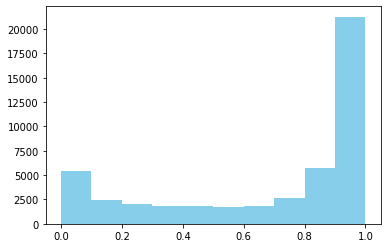

In [24]:
print(len(peak_preds))
print(sum(i > 0.5 for i in peak_preds))
plt.hist(peak_preds,color='skyblue')

### Differential Model

In [21]:
#differential model second
keras_model_weights2 = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.h5"
keras_model_json2 = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.json"

keras_model2 = model_from_json(open(keras_model_json2).read())
keras_model2.load_weights(keras_model_weights2)
keras_model2.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])

In [22]:
peak_preds2 = keras_model2.predict(x_vis).flatten()

46782
19880


(array([14743.,  4744.,  3222.,  2280.,  1913.,  1879.,  2482.,  3082.,
         3897.,  8540.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

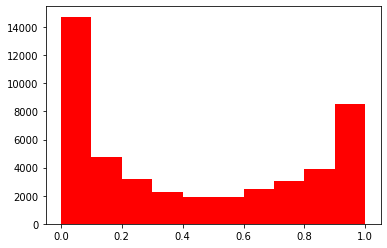

In [25]:
print(len(peak_preds2))
print(sum(i > 0.5 for i in peak_preds2))
plt.hist(peak_preds2,color='red')

### Cutting down the data lists

### Keep seqs where at least one of preds for (seq and rc) is above threshold

In [26]:
#easiest thing is to just put both in the df then can be modular about cutting this down
homeo_preds = peak_preds[::2]
homeo_preds_rc = peak_preds[1::2]
diff_preds = peak_preds2[::2]
diff_preds_rc = peak_preds2[1::2]

In [27]:
bed_df["Homeostatic Predictions"] = homeo_preds
bed_df["Homeostatic Predictions RC"] = homeo_preds_rc
bed_df["Differential Predictions"] = diff_preds
bed_df["Differential Predictions RC"] = diff_preds_rc

/gpfs/data01/glasslab/home/hmummey/.conda/envs/zs-deeplift/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/gpfs/data01/glasslab/home/hmummey/.conda/envs/zs-deeplift/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/gpfs/data01/glasslab/home/hmummey/.conda/envs/zs-deeplift/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is t

In [28]:
print(len(bed_df))
bed_df.head()

23391


,chr,start,end,strand,Homeostatic Predictions,Homeostatic Predictions RC,Differential Predictions,Differential Predictions RC
0,chr8,40594980,40595979,+,0.931042,0.896996,0.999982,0.998347
1,chr17,47395262,47396261,+,0.925941,0.945431,0.889835,0.820193
2,chr6,127351305,127352304,+,0.044167,0.472229,0.753739,0.786870
3,chr18,36727335,36728334,+,0.502969,0.830902,0.875302,0.787264
4,chr12,3854104,3855103,+,0.697546,0.739788,0.848480,0.584783


In [29]:
save_name = "/home/hmummey/data/ATAC/combined_peaks/round3/mergePeaks_C57_control_C57_AMLNDiet_given_all_round2_with_predictions.bed"
bed_df.to_csv(save_name, index=False, header=True, sep="\t")

### Cut down bed df and then remake the dataset

Homeostatic model predicts positive

In [31]:
#first cut (just take a row if one passes)
save_rows1 = []
for i in range(len(bed_df)):
    if bed_df.iloc[i,4] > 0.5 or bed_df.iloc[i,5] > 0.5:
        save_rows1.append(i)
        
print(len(save_rows1))

17909


In [32]:
bed_df_control = bed_df.iloc[save_rows1,:]
print(len(bed_df_control))
bed_df_control.head()

17909


,chr,start,end,strand,Homeostatic Predictions,Homeostatic Predictions RC,Differential Predictions,Differential Predictions RC
0,chr8,40594980,40595979,+,0.931042,0.896996,0.999982,0.998347
1,chr17,47395262,47396261,+,0.925941,0.945431,0.889835,0.820193
3,chr18,36727335,36728334,+,0.502969,0.830902,0.875302,0.787264
4,chr12,3854104,3855103,+,0.697546,0.739788,0.848480,0.584783
5,chr6,108740159,108741158,+,0.864241,0.827894,0.999877,0.935835


In [33]:
save_name = "/home/hmummey/data/ATAC/combined_peaks/round3/mergePeaks_C57_control_C57_AMLNDiet_given_all_round2_with_predictions_homeo+.bed"
bed_df_control.to_csv(save_name, index=False, header=False, sep="\t")

save_name = "/home/hmummey/data/ATAC/combined_peaks/mergePeaks_C57_control_C57_AMLNDiet_given_with_predictions_control+_withhead.bed"
bed_df_control.to_csv(save_name, index=False, header=True, sep="\t")

Differential model predicts positive

In [34]:
save_rows2 = []
for i in range(len(bed_df)):
    if bed_df.iloc[i,6] > 0.5 or bed_df.iloc[i,7] > 0.5:
        save_rows2.append(i)
        
print(len(save_rows2))

12322


In [36]:
bed_df_diff = bed_df.iloc[save_rows2,:]
print(len(bed_df_diff))
bed_df_diff.head()

12322


,chr,start,end,strand,Homeostatic Predictions,Homeostatic Predictions RC,Differential Predictions,Differential Predictions RC
0,chr8,40594980,40595979,+,0.931042,0.896996,0.999982,0.998347
1,chr17,47395262,47396261,+,0.925941,0.945431,0.889835,0.820193
2,chr6,127351305,127352304,+,0.044167,0.472229,0.753739,0.786870
3,chr18,36727335,36728334,+,0.502969,0.830902,0.875302,0.787264
4,chr12,3854104,3855103,+,0.697546,0.739788,0.848480,0.584783


In [37]:
save_name = "/home/hmummey/data/ATAC/combined_peaks/round3/mergePeaks_C57_control_C57_AMLNDiet_given_all_round2_with_predictions_diff+.bed"
bed_df_diff.to_csv(save_name, index=False, header=False, sep="\t")

save_name = "/home/hmummey/data/ATAC/combined_peaks/mergePeaks_C57_control_C57_AMLNDiet_given_with_predictions_amln+_withhead.bed"
bed_df_amln.to_csv(save_name, index=False, header=True, sep="\t")

In [38]:
save_rows3 = []
for i in range(len(bed_df)):
    if bed_df.iloc[i,6] > 0.5 or bed_df.iloc[i,7] > 0.5:
        if bed_df.iloc[i,4] > 0.5 or bed_df.iloc[i,5] > 0.5:
            save_rows3.append(i)
        
print(len(save_rows3))

10077


In [39]:
bed_df_both = bed_df.iloc[save_rows3,:]
print(len(bed_df_both))
bed_df_both.head()

10077


,chr,start,end,strand,Homeostatic Predictions,Homeostatic Predictions RC,Differential Predictions,Differential Predictions RC
0,chr8,40594980,40595979,+,0.931042,0.896996,0.999982,0.998347
1,chr17,47395262,47396261,+,0.925941,0.945431,0.889835,0.820193
3,chr18,36727335,36728334,+,0.502969,0.830902,0.875302,0.787264
4,chr12,3854104,3855103,+,0.697546,0.739788,0.848480,0.584783
5,chr6,108740159,108741158,+,0.864241,0.827894,0.999877,0.935835


In [40]:
save_name = "/home/hmummey/data/ATAC/combined_peaks/round3/mergePeaks_C57_control_C57_AMLNDiet_given_all_round2_with_predictions_both+.bed"
bed_df_both.to_csv(save_name, index=False, header=False, sep="\t")

save_name = "/home/hmummey/data/ATAC/combined_peaks/mergePeaks_C57_control_C57_AMLNDiet_given_with_predictions_both+_withhead.bed"
bed_df_both.to_csv(save_name, index=False, header=True, sep="\t")

## Now remake the datasets

In [43]:
#control+ --> delete first col!
data_path = "/home/hmummey/data/ATAC/combined_peaks/round3/mergePeaks_C57_control_C57_AMLNDiet_given_all_round2_with_predictions_homeo+.bed"
homeo_pos_data = data_prep(data_path, genomes, 1, "C57", size=300, rep=1, shift=None)
print(len(homeo_pos_data))

Scaled to 300
Generate replicates by shifting 0 bp
17909


In [42]:
#amln+ --> delete first col!
data_path = "/home/hmummey/data/ATAC/combined_peaks/round3/mergePeaks_C57_control_C57_AMLNDiet_given_all_round2_with_predictions_diff+.bed"
diff_pos_data = data_prep(data_path, genomes, 1, "C57", size=300, rep=1, shift=None)
print(len(diff_pos_data))

Scaled to 300
Generate replicates by shifting 0 bp
12322


In [41]:
#amln+ AND control+ --> delete first col!
data_path = "/home/hmummey/data/ATAC/combined_peaks/round3/mergePeaks_C57_control_C57_AMLNDiet_given_all_round2_with_predictions_both+.bed"
both_pos_data = data_prep(data_path, genomes, 1, "C57", size=300, rep=1, shift=None)
print(len(both_pos_data))

Scaled to 300
Generate replicates by shifting 0 bp
10077


# Score nucleotide importance with DeepLIFT
## Do this twice for each model... the overlap set and the individual set

In [44]:
import deeplift
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict
from deeplift.util import get_shuffle_seq_ref_function
from deeplift.dinuc_shuffle import dinuc_shuffle

## Define scoring function

In [45]:
#control model
#already compiled... making new one here that I'm not compiling
keras_model_weights = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.controlhomeo.epo20.RandomShift0bp.h5"
keras_model_json = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.controlhomeo.epo20.RandomShift0bp.json"

keras_model1 = model_from_json(open(keras_model_json).read())
keras_model1.load_weights(keras_model_weights)

#new to run
nonlinear_mxts_mode = NonlinearMxtsMode.DeepLIFT_GenomicsDefault
deeplift_method = kc.convert_model_from_saved_files(
            h5_file=keras_model_weights,
            json_file=keras_model_json,
            nonlinear_mxts_mode=nonlinear_mxts_mode)
scoring_func = deeplift_method.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault

For layer 2 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 7 the preceding linear layer is 5 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 12 the preceding linear layer is 10 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 16 the preceding linear layer is 15 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sig

In [46]:
#control model
#already compiled... making new one here that I'm not compiling
keras_model_weights2 = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.h5"
keras_model_json2 = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.json"

keras_model2 = model_from_json(open(keras_model_json2).read())
keras_model2.load_weights(keras_model_weights2)

#new to run
nonlinear_mxts_mode = NonlinearMxtsMode.DeepLIFT_GenomicsDefault
deeplift_method2 = kc.convert_model_from_saved_files(
            h5_file=keras_model_weights2,
            json_file=keras_model_json2,
            nonlinear_mxts_mode=nonlinear_mxts_mode)
scoring_func2 = deeplift_method2.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 2 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 7 the preceding linear layer is 5 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 12 the preceding linear layer is 10 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 16 the preceding linear layer is 15 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sigm

## Specify reference and compute importance

In [47]:
#making 3 onehotseqs from all 3 pos data sets
x_vis_homeo, y_vis_homeo, info_vis_homeo = dataset2onehot(homeo_pos_data, False)
x_vis_diff, y_vis_diff, info_vis_diff = dataset2onehot(diff_pos_data, False)
x_vis_both, y_vis_both, info_vis_both = dataset2onehot(both_pos_data, False)

In [48]:
print(x_vis_homeo.shape)
print(y_vis_homeo.shape)
print(x_vis_diff.shape)
print(y_vis_diff.shape)
print(x_vis_both.shape)
print(y_vis_both.shape)

(35818, 300, 4)
(35818,)
(24644, 300, 4)
(24644,)
(20154, 300, 4)
(20154,)


### Homeostatic model 
- Scores 1 = homeo pos data
- Scores 2 = both pos data

In [50]:
batch_size = 128
background = OrderedDict([('A', 0.25), ('C', 0.25), ('G', 0.25), ('T', 0.25)])
scores1 = np.array(scoring_func(task_idx=0, input_data_list=[x_vis_homeo], batch_size=batch_size, 
                               input_references_list=[np.array([background['A'], 
                                                                background['C'], 
                                                                background['G'], 
                                                                background['T']])[None,None,:]],
                               progress_update=1000))
scores1 = np.sum(scores1, axis=2)

Done 0
Done 16000
Done 32000


In [51]:
batch_size = 128 
background = OrderedDict([('A', 0.25), ('C', 0.25), ('G', 0.25), ('T', 0.25)])
scores2 = np.array(scoring_func(task_idx=0, input_data_list=[x_vis_both], batch_size=batch_size, 
                               input_references_list=[np.array([background['A'], 
                                                                background['C'], 
                                                                background['G'], 
                                                                background['T']])[None,None,:]],
                               progress_update=1000))
scores2 = np.sum(scores2, axis=2)

Done 0
Done 16000


### Differential model
- Scores 3 = diff pos data
- Scores 4 = both pos data

In [52]:
batch_size = 128 
background = OrderedDict([('A', 0.25), ('C', 0.25), ('G', 0.25), ('T', 0.25)])
scores3 = np.array(scoring_func2(task_idx=0, input_data_list=[x_vis_diff], batch_size=batch_size, 
                               input_references_list=[np.array([background['A'], 
                                                                background['C'], 
                                                                background['G'], 
                                                                background['T']])[None,None,:]],
                               progress_update=1000))
scores3 = np.sum(scores3, axis=2)

Done 0
Done 16000


In [53]:
batch_size = 128 
background = OrderedDict([('A', 0.25), ('C', 0.25), ('G', 0.25), ('T', 0.25)])
scores4 = np.array(scoring_func2(task_idx=0, input_data_list=[x_vis_both], batch_size=batch_size, 
                               input_references_list=[np.array([background['A'], 
                                                                background['C'], 
                                                                background['G'], 
                                                                background['T']])[None,None,:]],
                               progress_update=1000))
scores4 = np.sum(scores4, axis=2)

Done 0
Done 16000


## Get nucleotide-level max importance from original and reverse compliment sequences

In [58]:
bed_df_control.head()

,chr,start,end,strand,Homeostatic Predictions,Homeostatic Predictions RC,Differential Predictions,Differential Predictions RC
0,chr8,40594980,40595979,+,0.931042,0.896996,0.999982,0.998347
1,chr17,47395262,47396261,+,0.925941,0.945431,0.889835,0.820193
3,chr18,36727335,36728334,+,0.502969,0.830902,0.875302,0.787264
4,chr12,3854104,3855103,+,0.697546,0.739788,0.848480,0.584783
5,chr6,108740159,108741158,+,0.864241,0.827894,0.999877,0.935835


In [59]:
bed_df_diff.head()

,chr,start,end,strand,Homeostatic Predictions,Homeostatic Predictions RC,Differential Predictions,Differential Predictions RC
0,chr8,40594980,40595979,+,0.931042,0.896996,0.999982,0.998347
1,chr17,47395262,47396261,+,0.925941,0.945431,0.889835,0.820193
2,chr6,127351305,127352304,+,0.044167,0.472229,0.753739,0.786870
3,chr18,36727335,36728334,+,0.502969,0.830902,0.875302,0.787264
4,chr12,3854104,3855103,+,0.697546,0.739788,0.848480,0.584783


In [60]:
bed_df_both.head()

,chr,start,end,strand,Homeostatic Predictions,Homeostatic Predictions RC,Differential Predictions,Differential Predictions RC
0,chr8,40594980,40595979,+,0.931042,0.896996,0.999982,0.998347
1,chr17,47395262,47396261,+,0.925941,0.945431,0.889835,0.820193
3,chr18,36727335,36728334,+,0.502969,0.830902,0.875302,0.787264
4,chr12,3854104,3855103,+,0.697546,0.739788,0.848480,0.584783
5,chr6,108740159,108741158,+,0.864241,0.827894,0.999877,0.935835


In [54]:
#building an index for use in all, peak_ids (chr_start_end)
#bed_df_both.head()

peak_ids_homeo = []
for row in range(len(bed_df_control)):
    peak = str(bed_df_control.iloc[row,0]) + "_" + str(bed_df_control.iloc[row,1]) + "_" + str(bed_df_control.iloc[row,2])
    peak_ids_homeo.append(peak)

In [55]:
#building an index for use in all, peak_ids (chr_start_end)
#bed_df_both.head()

peak_ids_diff = []
for row in range(len(bed_df_diff)):
    peak = str(bed_df_diff.iloc[row,0]) + "_" + str(bed_df_diff.iloc[row,1]) + "_" + str(bed_df_diff.iloc[row,2])
    peak_ids_diff.append(peak)

In [56]:
#building an index for use in all, peak_ids (chr_start_end)
#bed_df_both.head()

peak_ids_both = []
for row in range(len(bed_df_both)):
    peak = str(bed_df_both.iloc[row,0]) + "_" + str(bed_df_both.iloc[row,1]) + "_" + str(bed_df_both.iloc[row,2])
    peak_ids_both.append(peak)

In [61]:
print(len(peak_ids_homeo))
print(peak_ids_homeo[:5])
print(len(peak_ids_diff))
print(peak_ids_diff[:5])
print(len(peak_ids_both))
print(peak_ids_both[:5])

17909
['chr8_40594980_40595979', 'chr17_47395262_47396261', 'chr18_36727335_36728334', 'chr12_3854104_3855103', 'chr6_108740159_108741158']
12322
['chr8_40594980_40595979', 'chr17_47395262_47396261', 'chr6_127351305_127352304', 'chr18_36727335_36728334', 'chr12_3854104_3855103']
10077
['chr8_40594980_40595979', 'chr17_47395262_47396261', 'chr18_36727335_36728334', 'chr12_3854104_3855103', 'chr6_108740159_108741158']


### Homeostatic
- Scores 1 = homeo pos data
- Scores 2 = both pos data

In [62]:
weights1 = []
for sample_index in range(len(scores1)//2):
    sample_scores1 = np.array([scores1[sample_index*2], scores1[sample_index*2+1][::-1]])
    sample_score1 = np.array([sample_scores1[j,i] for i,j in enumerate(np.argmax(np.absolute(sample_scores1), axis=0))])
    weights1.append(sample_score1)
weights1 = np.array(weights1)
weights1.shape

(17909, 300)

In [64]:
#writing this to a file so can use in other notebooks
#want to include some sort of index here too... maybe peak IDs?

control_nt_weights1 = "/home/hmummey/model/210301_NCoRWT_secondset/C57_homeostatic_nt_weights_unionpeaks_homeo+.txt"
weights_df1 = pd.DataFrame(weights1)
weights_df1.index = peak_ids_homeo
print(weights_df1.shape)
#control_weights_df.head()
weights_df1.to_csv(control_nt_weights1,index = True, sep='\t')

(17909, 300)


In [66]:
weights2 = []
for sample_index in range(len(scores2)//2):
    sample_scores2 = np.array([scores2[sample_index*2], scores2[sample_index*2+1][::-1]])
    sample_score2 = np.array([sample_scores2[j,i] for i,j in enumerate(np.argmax(np.absolute(sample_scores2), axis=0))])
    weights2.append(sample_score2)
weights2 = np.array(weights2)
weights2.shape

(10077, 300)

In [68]:
#writing this to a file so can use in other notebooks
#want to include some sort of index here too... maybe peak IDs?

control_nt_weights2 = "/home/hmummey/model/210301_NCoRWT_secondset/C57_homeostatic_nt_weights_unionpeaks_both+.txt"
weights_df2 = pd.DataFrame(weights2)
weights_df2.index = peak_ids_both
print(weights_df2.shape)
#control_weights_df.head()
weights_df2.to_csv(control_nt_weights2,index = True, sep='\t')

(10077, 300)


### Differential model
- Scores 3 = diff pos data
- Scores 4 = both pos data

In [70]:
weights3 = []
for sample_index in range(len(scores3)//2):
    sample_scores3 = np.array([scores3[sample_index*2], scores3[sample_index*2+1][::-1]])
    sample_score3 = np.array([sample_scores3[j,i] for i,j in enumerate(np.argmax(np.absolute(sample_scores3), axis=0))])
    weights3.append(sample_score3)
weights3 = np.array(weights3)
weights3.shape

(12322, 300)

In [72]:
#writing this to a file so can use in other notebooks
#want to include some sort of index here too... maybe peak IDs?

diff_nt_weights3 = "/home/hmummey/model/210301_NCoRWT_secondset/C57_AMLN_diff_nt_weights_unionpeaks_diff+.txt"
weights_df3 = pd.DataFrame(weights3)
weights_df3.index = peak_ids_diff
print(weights_df3.shape)
#control_weights_df.head()
weights_df3.to_csv(diff_nt_weights3,index = True, sep='\t')

(12322, 300)


In [73]:
weights4 = []
for sample_index in range(len(scores4)//2):
    sample_scores4 = np.array([scores4[sample_index*2], scores4[sample_index*2+1][::-1]])
    sample_score4 = np.array([sample_scores4[j,i] for i,j in enumerate(np.argmax(np.absolute(sample_scores4), axis=0))])
    weights4.append(sample_score4)
weights4 = np.array(weights4)
weights4.shape

(10077, 300)

In [74]:
#writing this to a file so can use in other notebooks
#want to include some sort of index here too... maybe peak IDs?

diff_nt_weights4 = "/home/hmummey/model/210301_NCoRWT_secondset/C57_AMLN_diff_nt_weights_unionpeaks_both+.txt"
weights_df4 = pd.DataFrame(weights4)
weights_df4.index = peak_ids_both
print(weights_df4.shape)
#control_weights_df.head()
weights_df4.to_csv(diff_nt_weights4,index = True, sep='\t')

(10077, 300)


### Smooth Weights

In [65]:
proc_range = 1
smooth_weights1 = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in weights1])
print(smooth_weights1.shape)

(17909, 300)


In [69]:
proc_range = 1
smooth_weights2 = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in weights2])
print(smooth_weights2.shape)

(10077, 300)


In [75]:
proc_range = 1
smooth_weights3 = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in weights3])
print(smooth_weights3.shape)

(12322, 300)


In [76]:
proc_range = 1
smooth_weights4 = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in weights4])
print(smooth_weights4.shape)

(10077, 300)


# Visualize importance scores for individual site

In [77]:
homeo_pos_data[0]

('CTCAAGTCAGAAAATCCCCGAGGTTTTCACCTCTTCTGTCACAGCAGTCTGGAAAGGGCCAGGCTTACTGGGCTGGGAGTTTCTCTGGAAAAGAAATGGCAAGTGACACACAGCTTTCAGTCTGGGTGATGCAGGGCTCCGGTTACTATGCGCAAATGAGTCACATTGGTGGTTAATTCTAAGGGGAAAGTCATCAAAGCAGCAGCATGGAGAAAGTACCATTCAGTGGCTGTGCTTCACTCTCTCTCTCTCCTTCCTTGTTCAAGGACAGCTGAATAGTTGAGAAACAAAGACATCCGA',
 1,
 'chr8',
 40595329,
 40595629,
 'chr8_40595329_40595629_C57')

In [78]:
diff_pos_data[0]

('CTCAAGTCAGAAAATCCCCGAGGTTTTCACCTCTTCTGTCACAGCAGTCTGGAAAGGGCCAGGCTTACTGGGCTGGGAGTTTCTCTGGAAAAGAAATGGCAAGTGACACACAGCTTTCAGTCTGGGTGATGCAGGGCTCCGGTTACTATGCGCAAATGAGTCACATTGGTGGTTAATTCTAAGGGGAAAGTCATCAAAGCAGCAGCATGGAGAAAGTACCATTCAGTGGCTGTGCTTCACTCTCTCTCTCTCCTTCCTTGTTCAAGGACAGCTGAATAGTTGAGAAACAAAGACATCCGA',
 1,
 'chr8',
 40595329,
 40595629,
 'chr8_40595329_40595629_C57')

In [79]:
both_pos_data[0]

('CTCAAGTCAGAAAATCCCCGAGGTTTTCACCTCTTCTGTCACAGCAGTCTGGAAAGGGCCAGGCTTACTGGGCTGGGAGTTTCTCTGGAAAAGAAATGGCAAGTGACACACAGCTTTCAGTCTGGGTGATGCAGGGCTCCGGTTACTATGCGCAAATGAGTCACATTGGTGGTTAATTCTAAGGGGAAAGTCATCAAAGCAGCAGCATGGAGAAAGTACCATTCAGTGGCTGTGCTTCACTCTCTCTCTCTCCTTCCTTGTTCAAGGACAGCTGAATAGTTGAGAAACAAAGACATCCGA',
 1,
 'chr8',
 40595329,
 40595629,
 'chr8_40595329_40595629_C57')

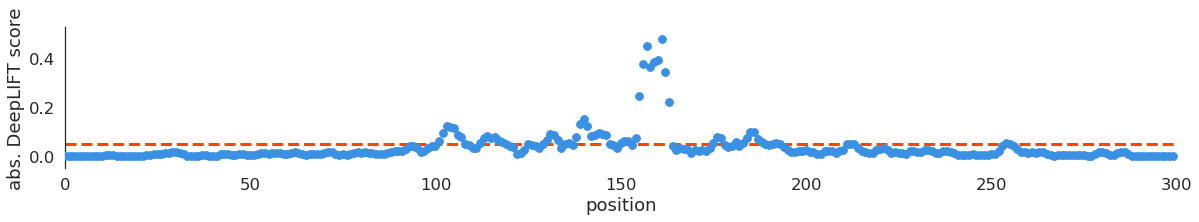

In [80]:
s = 'chr8_40595329_40595629_C57'

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(17,3.2))
w = np.abs(smooth_weights1[np.array(homeo_pos_data)[:,-1] == s][0])
plt.scatter(np.arange(len(w)), w, s=60, c='#3A90E3',zorder=10)
plt.axhline(np.sort(w)[240], c='orangered', linestyle='--', linewidth=3)
plt.xlim(0,300)
plt.xlabel('position')
plt.ylabel('abs. DeepLIFT score')
sns.despine(top=True, bottom=True)
plt.tight_layout()

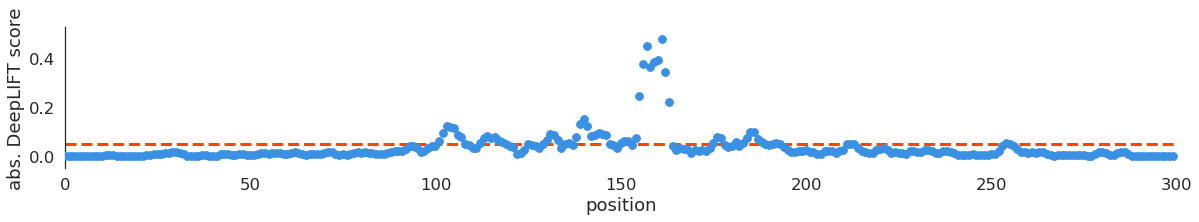

In [81]:
s = 'chr8_40595329_40595629_C57'

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(17,3.2))
w = np.abs(smooth_weights2[np.array(both_pos_data)[:,-1] == s][0])
plt.scatter(np.arange(len(w)), w, s=60, c='#3A90E3',zorder=10)
plt.axhline(np.sort(w)[240], c='orangered', linestyle='--', linewidth=3)
plt.xlim(0,300)
plt.xlabel('position')
plt.ylabel('abs. DeepLIFT score')
sns.despine(top=True, bottom=True)
plt.tight_layout()

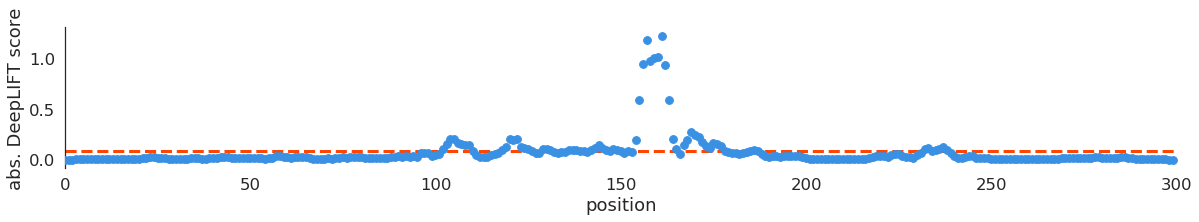

In [82]:
s = 'chr8_40595329_40595629_C57'

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(17,3.2))
w = np.abs(smooth_weights3[np.array(diff_pos_data)[:,-1] == s][0])
plt.scatter(np.arange(len(w)), w, s=60, c='#3A90E3',zorder=10)
plt.axhline(np.sort(w)[240], c='orangered', linestyle='--', linewidth=3)
plt.xlim(0,300)
plt.xlabel('position')
plt.ylabel('abs. DeepLIFT score')
sns.despine(top=True, bottom=True)
plt.tight_layout()

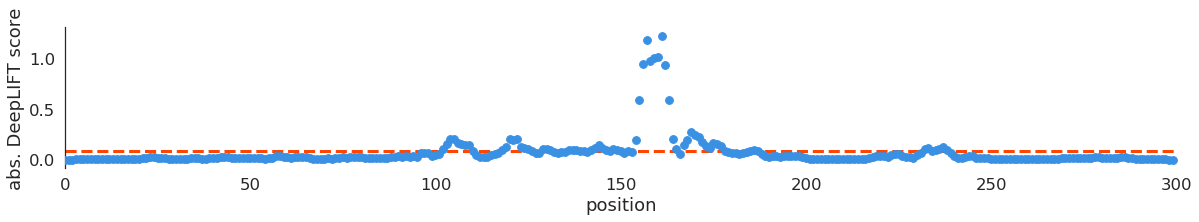

In [83]:
s = 'chr8_40595329_40595629_C57'

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(17,3.2))
w = np.abs(smooth_weights4[np.array(both_pos_data)[:,-1] == s][0])
plt.scatter(np.arange(len(w)), w, s=60, c='#3A90E3',zorder=10)
plt.axhline(np.sort(w)[240], c='orangered', linestyle='--', linewidth=3)
plt.xlim(0,300)
plt.xlabel('position')
plt.ylabel('abs. DeepLIFT score')
sns.despine(top=True, bottom=True)
plt.tight_layout()